In [354]:
import pandas as pd
import numpy as np
from astropy.coordinates import SkyCoord
from astropy import units as u
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from tqdm import tqdm

df = pd.read_csv("~/hst_FINAL.csv")

df = df.rename(columns={'sci_data_set_name': 'obs_id'})

# Create a shortened identifier.

"""
The data downloading process looks like the following:

1. Use MastMissions to query the list of observations and their metadata, like ra/dec

2. Filtering process to make sure there are no overlapping observations.

3. Use Observations to pull the names of the data files associated with each observation.

4. Pull the data by wget all those file links.

5. Preprocess.

Note that the data file names use the first 6 chars of obs_id from this observations array
that we have created. That's why we create the shortened identifier, to match
observations to product file names. This will be used later.
"""

df['obs_id_short'] = df['obs_id'].str[:6]

RA_NAME = 'sci_ra'
DEC_NAME = 'sci_dec'

assert df[RA_NAME].isna().sum() < 10
assert df[DEC_NAME].isna().sum() < 10

df = df.dropna(subset=[RA_NAME, DEC_NAME])

# Sample data: let's create an example array of latitudes and longitudes
# MAKE SURE TO PUT RA=LON, DEC=LAT
latitudes = np.array(df[DEC_NAME])  # Example latitudes
longitudes = np.array(df[RA_NAME])  # Example longitudes

n_points = len(latitudes)

# Repeat each point n_points times for lat1, lon1
lat1 = np.repeat(latitudes, n_points)
lon1 = np.repeat(longitudes, n_points)

# Tile the whole array n_points times for lat2, lon2
lat2 = np.tile(latitudes, n_points)
lon2 = np.tile(longitudes, n_points)

# Calculates angular separation between two spherical coords
# This can be lat/lon or ra/dec
# Taken from astropy
def angular_separation_deg(lon1, lat1, lon2, lat2):
    lon1 = np.deg2rad(lon1)
    lon2 = np.deg2rad(lon2)
    lat1 = np.deg2rad(lat1)
    lat2 = np.deg2rad(lat2)
    
    sdlon = np.sin(lon2 - lon1)
    cdlon = np.cos(lon2 - lon1)
    slat1 = np.sin(lat1)
    slat2 = np.sin(lat2)
    clat1 = np.cos(lat1)
    clat2 = np.cos(lat2)

    num1 = clat2 * sdlon
    num2 = clat1 * slat2 - slat1 * clat2 * cdlon
    denominator = slat1 * slat2 + clat1 * clat2 * cdlon

    return np.rad2deg(np.arctan2(np.hypot(num1, num2), denominator))

# Compute the pairwise angular separations
angular_separations = angular_separation_deg(lon1, lat1, lon2, lat2)

# Reshape the result into a matrix form
angular_separations_matrix = angular_separations.reshape(n_points, n_points)

def check_symmetric(a, rtol=1e-05, atol=1e-07):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

print("Symmetric?")
print(check_symmetric(angular_separations_matrix))
print(len(angular_separations_matrix))

Symmetric?
True
6555


In [355]:
print(len(angular_separations_matrix))

6555


In [356]:
HUBBLE_FOV = 0.057
#JWST_FOV = 0.0172222

THRESH = 2 * HUBBLE_FOV

clustering = AgglomerativeClustering(n_clusters=None, metric='precomputed', linkage='single', distance_threshold=THRESH)
labels = clustering.fit_predict(angular_separations_matrix)

df['label'] = labels

print(pd.Series(labels).value_counts())

def max_subset_with_min_distance(points, min_distance):
    subset = []
    for i, row in points.iterrows():
        if all(angular_separation_deg(row[RA_NAME], row[DEC_NAME], existing_point[RA_NAME], existing_point[DEC_NAME]) >= min_distance for existing_point in subset):
            subset.append(row)
    return subset

all_subsets = []

for label in tqdm(np.unique(labels)):
    cds = df[labels == label]
    subset = max_subset_with_min_distance(cds, THRESH)
    all_subsets.extend(subset)

print("Max subset with minimum distance:", len(all_subsets))

df = pd.DataFrame(all_subsets)

128     369
60      284
156     198
99      163
78      118
       ... 
2025      1
605       1
731       1
1129      1
561       1
Length: 2215, dtype: int64


100%|█████████████████████████████████████| 2215/2215 [00:00<00:00, 3215.33it/s]


Max subset with minimum distance: 2367


In [357]:
from astroquery.mast import Observations

# Query for data with the specified obs_id
result = Observations.query_criteria(obs_id=df["obs_id"])

In [358]:
from astropy.table import unique, vstack, Table

matched_obs = result

# Split the observations into "chunks"
sz_chunk = 1
chunks = [matched_obs[i:i+sz_chunk] for i in range(0,len(matched_obs), sz_chunk)]

# Get the list of products for each chunk
t = []
for chunk in tqdm(chunks):
    out = Observations.get_product_list(chunk)
    out = out[out['productSubGroupDescription'] == 'RAW']
    out = out[out['dataRights'] == 'PUBLIC']
    out = out.to_pandas()
    if len(out) > 0:
        t.append(out.iloc[0])

100%|███████████████████████████████████████| 2143/2143 [07:54<00:00,  4.52it/s]


In [359]:
files = pd.DataFrame(t)

'''
# Ensure we only keep raw data files
files = files[files['productSubGroupDescription'] == 'RAW']

# Create a shortened identified
files['obs_id_short'] = files['obs_id'].str[:6]
files = files.drop_duplicates(subset='obs_id_short')
'''

print(f"There are {len(files)} unique files, which are {sum(files['size'])/10**9:.1f} GB in size.")

There are 2118 unique files, which are 72.9 GB in size.


In [360]:
files

obsID obs_collection dataproduct_type     obs_id  \
0   26113888            HST            image  jdq318n8q   
0   24979066            HST            image  jcoz32dvq   
0   25874266            HST            image  jdba3nvyq   
0   24042703            HST            image  j96l03bcq   
0   26270229            HST            image  jdrz3ytfq   
..       ...            ...              ...        ...   
0   24085175            HST            image  jb2p31fnq   
0   68563813            HST            image  jenm44ygq   
0   25857452            HST            image  jd9r08r2q   
0   24127301            HST            image  jcdm96g1q   
0   24035175            HST            image  j94se5qmq   

                                          description type  \
0   DADS RAW file - Raw exposure COS/NICMOS/STIS/W...    S   
0   DADS RAW file - Raw exposure COS/NICMOS/STIS/W...    S   
0   DADS RAW file - Raw exposure COS/NICMOS/STIS/W...    S   
0   DADS RAW file - Raw exposure COS/NICMOS/STIS/W...    S   
0   DADS RAW file - Raw exposure COS/NICMOS/STIS/W...    S   
..                                                ...  ...   
0   DADS RAW file - Raw exposure COS/NICMOS/STIS/W...    S   
0   DADS RAW file - Raw exposure COS/NICMOS/STIS/W...    S   
0   DADS RAW file - Raw exposure COS/NICMOS/STIS/W...    S   
0   DADS RAW file - Raw exposure COS/NICMOS/STIS/W...    S   
0   DADS RAW file - Raw exposure COS/NICMOS/STIS/W...    S   

                                dataURI productType  productGroupDescription  \
0   mast:HST/product/jdq318n8q_raw.fits     SCIENCE                      NaN   
0   mast:HST/product/jcoz32dvq_raw.fits     SCIENCE                      NaN   
0   mast:HST/product/jdba3nvyq_raw.fits     SCIENCE                      NaN   
0   mast:HST/product/j96l03bcq_raw.fits     SCIENCE                      NaN   
0   mast:HST/product/jdrz3ytfq_raw.fits     SCIENCE                      NaN   
..                                  ...         ...                      ...   
0   mast:HST/product/jb2p31fnq_raw.fits     SCIENCE                      NaN   
0   mast:HST/product/jenm44ygq_raw.fits     SCIENCE                      NaN   
0   mast:HST/product/jd9r08r2q_raw.fits     SCIENCE                      NaN   
0   mast:HST/product/jcdm96g1q_raw.fits     SCIENCE                      NaN   
0   mast:HST/product/j94se5qmq_raw.fits     SCIENCE                      NaN   

   productSubGroupDescription  productDocumentationURL project  prvversion  \
0                         RAW                      NaN  CALACS         NaN   
0                         RAW                      NaN  CALACS         NaN   
0                         RAW                      NaN  CALACS         NaN   
0                         RAW                      NaN  CALACS         NaN   
0                         RAW                      NaN  CALACS         NaN   
..                        ...                      ...     ...         ...   
0                         RAW                      NaN  CALACS         NaN   
0                         RAW                      NaN  CALACS         NaN   
0                         RAW                      NaN  CALACS         NaN   
0                         RAW                      NaN  CALACS         NaN   
0                         RAW                      NaN  CALACS         NaN   

   proposal_id     productFilename      size parent_obsid dataRights  \
0        15213  jdq318n8q_raw.fits  34344000     26114025     PUBLIC   
0        13671  jcoz32dvq_raw.fits  34344000     24981158     PUBLIC   
0        14840  jdba3nvyq_raw.fits  34344000     25874435     PUBLIC   
0        10438  j96l03bcq_raw.fits  34344000     24825269     PUBLIC   
0        15446  jdrz3ytfq_raw.fits  34344000     26270246     PUBLIC   
..         ...                 ...       ...          ...        ...   
0        11613  jb2p31fnq_raw.fits  34344000     24831290     PUBLIC   
0        16711  jenm44ygq_raw.fits  34344000     68565137     PUBLIC   
0      

In [ ]:
sz_chunk = 25
chunks = [files[i:i+sz_chunk] for i in range(0,len(files), sz_chunk)]

# Get the list of products for each chunk
t = []
for chunk in tqdm(chunks):
    manifest = Observations.download_products(chunk['obsID'], curl_flag=True)

  0%|                                                    | 0/87 [00:00<?, ?it/s]

  1%|▌                                           | 1/87 [00:10<14:32, 10.15s/it]

  2%|█                                           | 2/87 [00:20<14:42, 10.38s/it]

  3%|█▌                                          | 3/87 [00:35<17:03, 12.19s/it]

  5%|██                                          | 4/87 [00:45<15:59, 11.56s/it]

  6%|██▌                                         | 5/87 [00:55<15:00, 10.99s/it]

  7%|███                                         | 6/87 [01:04<13:49, 10.24s/it]

  8%|███▌                                        | 7/87 [01:13<13:03,  9.80s/it]

  9%|████                                        | 8/87 [01:27<14:37, 11.10s/it]

 10%|████▌                                       | 9/87 [01:38<14:23, 11.07s/it]

 11%|████▉                                      | 10/87 [01:48<13:44, 10.71s/it]

 13%|█████▍                                     | 11/87 [01:59<13:49, 10.92s/it]

 14%|█████▉                                     | 12/87 [02:08<12:45, 10.20s/it]

 15%|██████▍                                    | 13/87 [02:16<12:02,  9.77s/it]

 16%|██████▉                                    | 14/87 [02:26<12:00,  9.88s/it]

 17%|███████▍                                   | 15/87 [02:35<11:16,  9.39s/it]

 18%|███████▉                                   | 16/87 [02:44<11:12,  9.47s/it]

 20%|████████▍                                  | 17/87 [02:53<10:38,  9.12s/it]

 21%|████████▉                                  | 18/87 [03:03<10:44,  9.34s/it]

 22%|█████████▍                                 | 19/87 [03:11<10:25,  9.19s/it]

 23%|█████████▉                                 | 20/87 [03:20<10:05,  9.04s/it]

 24%|██████████▍                                | 21/87 [03:30<10:13,  9.29s/it]

 25%|██████████▊                                | 22/87 [03:44<11:37, 10.73s/it]

 26%|███████████▎                               | 23/87 [03:55<11:25, 10.71s/it]

 28%|███████████▊                               | 24/87 [04:04<10:53, 10.38s/it]

 29%|████████████▎                              | 25/87 [04:14<10:36, 10.27s/it]

 30%|████████████▊                              | 26/87 [04:23<09:51,  9.70s/it]

 31%|█████████████▎                             | 27/87 [04:32<09:39,  9.66s/it]

 32%|█████████████▊                             | 28/87 [04:43<09:44,  9.91s/it]

 33%|██████████████▎                            | 29/87 [04:52<09:27,  9.79s/it]

 34%|██████████████▊                            | 30/87 [05:02<09:19,  9.82s/it]

 36%|███████████████▎                           | 31/87 [05:12<09:12,  9.87s/it]

 37%|███████████████▊                           | 32/87 [05:23<09:27, 10.32s/it]

 38%|████████████████▎                          | 33/87 [05:33<09:06, 10.12s/it]

 39%|████████████████▊                          | 34/87 [05:43<08:59, 10.17s/it]

 40%|█████████████████▎                         | 35/87 [05:52<08:21,  9.64s/it]

 41%|█████████████████▊                         | 36/87 [06:01<08:01,  9.44s/it]

 43%|██████████████████▎                        | 37/87 [06:08<07:24,  8.89s/it]

 44%|██████████████████▊                        | 38/87 [06:19<07:35,  9.30s/it]

 45%|███████████████████▎                       | 39/87 [06:27<07:18,  9.13s/it]

 46%|███████████████████▊                       | 40/87 [06:36<07:06,  9.08s/it]

 47%|████████████████████▎                      | 41/87 [06:44<06:36,  8.63s/it]

 48%|████████████████████▊                      | 42/87 [06:53<06:33,  8.74s/it]

 49%|█████████████████████▎                     | 43/87 [07:02<06:24,  8.75s/it]

 51%|█████████████████████▋                     | 44/87 [07:09<06:00,  8.39s/it]

 52%|██████████████████████▏                    | 45/87 [07:18<05:58,  8.54s/it]

 53%|██████████████████████▋                    | 46/87 [07:28<06:07,  8.97s/it]

 54%|███████████████████████▏                   | 47/87 [07:37<06:01,  9.05s/it]

 55%|███████████████████████▋                   | 48/87 [07:51<06:42, 10.31s/it]

 56%|████████████████████████▏                  | 49/87 [07:59<06:13,  9.84s/it]

 57%|████████████████████████▋                  | 50/87 [08:08<05:51,  9.49s/it]

 59%|█████████████████████████▏                 | 51/87 [08:16<05:24,  9.02s/it]

 60%|█████████████████████████▋                 | 52/87 [08:24<05:07,  8.79s/it]

 61%|██████████████████████████▏                | 53/87 [08:34<05:07,  9.04s/it]

 62%|██████████████████████████▋                | 54/87 [08:44<05:08,  9.36s/it]

 63%|███████████████████████████▏               | 55/87 [08:54<05:09,  9.66s/it]

 64%|███████████████████████████▋               | 56/87 [09:04<04:57,  9.60s/it]

 66%|████████████████████████████▏              | 57/87 [09:13<04:44,  9.48s/it]

 67%|████████████████████████████▋              | 58/87 [09:22<04:32,  9.38s/it]

 68%|█████████████████████████████▏             | 59/87 [09:31<04:15,  9.13s/it]

 69%|█████████████████████████████▋             | 60/87 [09:40<04:07,  9.16s/it]

 70%|██████████████████████████████▏            | 61/87 [09:49<03:59,  9.21s/it]

 71%|██████████████████████████████▋            | 62/87 [09:59<03:55,  9.41s/it]

 72%|███████████████████████████████▏           | 63/87 [10:09<03:49,  9.56s/it]

 74%|███████████████████████████████▋           | 64/87 [10:18<03:36,  9.39s/it]

 75%|████████████████████████████████▏          | 65/87 [10:27<03:25,  9.32s/it]

 76%|████████████████████████████████▌          | 66/87 [10:37<03:17,  9.40s/it]

 77%|█████████████████████████████████          | 67/87 [10:48<03:19,  9.99s/it]

 78%|█████████████████████████████████▌         | 68/87 [10:56<02:58,  9.40s/it]

 79%|██████████████████████████████████         | 69/87 [11:04<02:39,  8.89s/it]

 80%|██████████████████████████████████▌        | 70/87 [11:12<02:30,  8.83s/it]

 82%|███████████████████████████████████        | 71/87 [11:22<02:22,  8.91s/it]

 83%|███████████████████████████████████▌       | 72/87 [11:30<02:11,  8.80s/it]

 84%|████████████████████████████████████       | 73/87 [11:39<02:04,  8.89s/it]

 85%|████████████████████████████████████▌      | 74/87 [11:48<01:56,  8.93s/it]

 86%|█████████████████████████████████████      | 75/87 [11:57<01:45,  8.80s/it]

 87%|█████████████████████████████████████▌     | 76/87 [12:05<01:34,  8.62s/it]

 89%|██████████████████████████████████████     | 77/87 [12:14<01:26,  8.64s/it]

 90%|██████████████████████████████████████▌    | 78/87 [12:22<01:18,  8.70s/it]

 91%|███████████████████████████████████████    | 79/87 [12:31<01:09,  8.72s/it]

 92%|███████████████████████████████████████▌   | 80/87 [12:39<00:59,  8.56s/it]

 93%|████████████████████████████████████████   | 81/87 [12:47<00:49,  8.32s/it]

 94%|████████████████████████████████████████▌  | 82/87 [12:56<00:41,  8.35s/it]

 95%|█████████████████████████████████████████  | 83/87 [13:05<00:34,  8.60s/it]

 97%|█████████████████████████████████████████▌ | 84/87 [13:13<00:25,  8.44s/it]

 98%|██████████████████████████████████████████ | 85/87 [13:21<00:16,  8.45s/it]

 99%|██████████████████████████████████████████▌| 86/87 [13:30<00:08,  8.59s/it]

100%|███████████████████████████████████████████| 87/87 [13:39<00:00,  9.42s/it]


In [116]:
'''

import numpy as np
from astropy.io import fits
from astropy.table import Table
import glob

def create_combined_hubble_file(short_obs_id):
    
    file_list = list(files[files['obs_id_short'] == short_obs_id]['productFilename'])
    
    ccd1_data = []
    ccd2_data = []
    ccd1_times = []
    ccd2_times = []
    ccd1_headers = []
    ccd2_headers = []

    for file in file_list:
        with fits.open(file) as hdul:
            # Extract TIME-OBS from the primary header
            time_obs = hdul[0].header['TIME-OBS']

            # Extract data and headers from HDUs
            for hdu in [hdul[1], hdul[4]]:
                if hdu.header['CCDCHIP'] == 1:
                    ccd1_data.append(hdu.data)
                    ccd1_times.append(time_obs)
                    ccd1_headers.append(hdul[0].header.copy())
                elif hdu.header['CCDCHIP'] == 2:
                    ccd2_data.append(hdu.data)
                    ccd2_times.append(time_obs)
                    ccd2_headers.append(hdul[0].header.copy())

    # Sort the data based on TIME-OBS
    ccd1_times, ccd1_data, ccd1_headers = zip(*sorted(zip(ccd1_times, ccd1_data, ccd1_headers)))
    ccd2_times, ccd2_data, ccd2_headers = zip(*sorted(zip(ccd2_times, ccd2_data, ccd2_headers)))

    # Concatenate the data for each CCDCHIP
    ccd1_concat = np.stack(ccd1_data)
    ccd2_concat = np.stack(ccd2_data)

    # Function to create a new FITS file for a given CCDCHIP
    def create_fits_file(output_file, ccd_data, ccd_headers, ccd_chip):

        primary_hdu = fits.PrimaryHDU()
        primary_hdu.header['EXTEND'] = True
        primary_hdu.header['CCDCHIP'] = ccd_chip

        metadata_hdus = [fits.ImageHDU(header=header) for header in ccd_headers]

        # Create ImageHDU with concatenated data
        image_hdu = fits.ImageHDU(data=ccd_data, header=fits.Header({'CCDCHIP': ccd_chip}))

        # Create HDUList and write to a new FITS file
        hdulist = fits.HDUList([primary_hdu] + [image_hdu] + metadata_hdus)
        hdulist.writeto(output_file, overwrite=True)

    # Create FITS files for CCDCHIP 1 and 2
    create_fits_file(f'{short_obs_id}_ccd1.fits', ccd1_concat, ccd1_headers, 1)
    create_fits_file(f'{short_obs_id}_ccd2.fits', ccd2_concat, ccd2_headers, 2)

    print("New FITS files created successfully.")
    
'''

New FITS files created successfully.


251


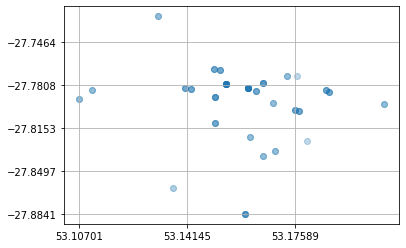

In [166]:
def visualize_label(df, LABEL=None):
    
    cds = df
    
    if LABEL is not None:
        cds = cds[labels == LABEL]

    ras, decs = [], []
    cmap = []
    
    print(len(cds))

    for i, cd in cds.iterrows():
        ras.append(cd[RA_NAME])
        decs.append(cd[DEC_NAME])

    if LABEL is None:
        # No gridlines, will be overwhelming

        # Compute the 2D histogram
        # Number of bins for x and y; adjust these based on your dataset
        bins = (30, 30)

        # Compute the histogram
        hist, xedges, yedges = np.histogram2d(ras, decs, bins=bins)
        
        N_cutoff = 50
        hist = np.clip(hist, 0, N_cutoff)

        # Generate a 2D histogram plot
        plt.figure(figsize=(8, 6))
        plt.imshow(hist, interpolation='nearest', origin='lower',
                   extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                   cmap='viridis')  # Choose a colormap (e.g., 'viridis', 'plasma', 'inferno')

        # Add labels and title if necessary
        plt.colorbar(label='Number of points in bin')
        plt.xlabel('RA')
        plt.ylabel('DEC')
        plt.title(f'2D Histogram of Point Density, clipped to {N_cutoff} points')

        # Show the plot
        plt.show()

        return
    else:
        fig = plt.figure()
        ax = fig.gca()
        ax.set_xticks(np.arange(np.min(ras), np.max(ras), THRESH))
        ax.set_yticks(np.arange(np.min(decs), np.max(decs), THRESH))
        plt.scatter(ras, decs, alpha=0.1)
        plt.grid()
        plt.show()

visualize_label(df, 4)

In [ ]:
from sklearn.model_selection import train_test_split

data = list(range(len(labels)))

# Perform the train-test split with an 80-20 ratio
train_indices, test_indices = train_test_split(data, test_size=0.2, random_state=42)

In [ ]:
sdss_test = all_sdss_data[all_sdss_data['cluster_label'].isin(test_indices)]
sdss_train = all_sdss_data[all_sdss_data['cluster_label'].isin(train_indices)]

In [ ]:
len(sdss_test)

In [ ]:
len(sdss_train)

In [ ]:
sdss_test

In [ ]:
test_data = pd.DataFrame(test_data)
train_data = pd.DataFrame(train_data)

In [ ]:
"""
Code to verify test/train pollution.
"""


import json
from math import radians, sin, cos, sqrt, atan2, degrees
import numpy as np
import matplotlib.pyplot as plt


# Function to load data from file
def load_data(file_path):
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            data.append(json.loads(line))
    return data

# Load data
train_file_path = '/Users/rithwik/Desktop/full_train.jsonl.txt'
test_file_path = '/Users/rithwik/Desktop/full_test.jsonl.txt'
#train_data = sdss_train
#test_data = sdss_test

# Define the threshold
threshold = 0.09*3

# Find test dataset rows with a minimum great circle distance less than the threshold
close_pairs = []

for i, test_point in test_data.iterrows():
    ra_test, dec_test = test_point['ra'], test_point['dec']
    distances = [(train_point, angular_separation_deg(ra_test, dec_test, train_point['ra'], train_point['dec'])) for i, train_point in train_data.iterrows()]
    closest_train_point, min_distance = min(distances, key=lambda x: x[1])
    if min_distance < threshold:
        close_pairs.append((test_point, closest_train_point, min_distance))

close_pairs_summary = [
    {
        "test_image_id": test_point['image_id'],
        "test_ra": test_point['ra'],
        "test_dec": test_point['dec'],
        "train_image_id": closest_train_point['image_id'],
        "train_ra": closest_train_point['ra'],
        "train_dec": closest_train_point['dec'],
        "min_distance_deg": min_distance
    }
    for test_point, closest_train_point, min_distance in close_pairs
]

# Print the results
result = "Success"
for pair in close_pairs_summary:
    print(pair)
    result = "FAIL"
    
print(f"Done. result is {result}")

In [ ]:
sdss_test.to_json('full_test1.jsonl', orient='records', lines=True)
sdss_train.to_json('full_train1.jsonl', orient='records', lines=True)

In [ ]:
import huggingface_hub
token = ''
huggingface_hub.login(token=token)

In [ ]:
from datasets import load_dataset
dataset = load_dataset("AstroCompress/GBI-16-4D", "tiny")
ds = dataset.with_format("np")

In [ ]:
df_jwst = pd.read_csv("/Users/rithwik/Desktop/jwst_all.csv")
df_jwst['opticalElementsList'] = df_jwst['opticalElements'].apply(lambda x: x.split(', '))

In [ ]:
pd.Series(sum(df_jwst['opticalElementsList'], [])).value_counts()

In [33]:
import os
from time import time
import pandas as pd

from imagecodecs import (
    imwrite, 
    imread, 
    jpeg2k_encode, 
    jpeg2k_decode, 
    jpegls_encode, 
    jpegls_decode, 
    jpegxl_encode,
    jpegxl_decode,
)


ALGORITHMS = ["JPEG_XL", "JPEG_2K", "JPEG_LS"]


ALGORITHMS = ["JPEG_2K"]

JPEG_ALGOS = {
    "JPEG_XL": [jpegxl_encode, jpegxl_decode, 101], 
    "JPEG_2K": [jpeg2k_encode, jpeg2k_decode, 0], 
    "JPEG_LS": [jpegls_encode, jpegls_decode, 0],
}

def benchmark_imagecodec_compression_algos(arr, compression_type, residual=-1):

    if compression_type in JPEG_ALGOS.keys():
        encoder, decoder, level = JPEG_ALGOS[compression_type]

        write_start_time = time()
        encoded = encoder(arr, level=level)
        write_time = time() - write_start_time
        
        read_start_time = time()
        decoded = decoder(encoded)
        read_time = time() - read_start_time
        
        assert np.array_equal(arr, decoded)

    buflength = len(encoded)
    
    
    return {compression_type + "_BYTES": buflength / arr.size,
            compression_type + "_WRITE_RUNTIME": write_time,
            compression_type + "_READ_RUNTIME": read_time
           }



file_paths = ["/Users/rithwik/Desktop/cube_center_run1752_camcol1_f164_82-5-800-800.fits"]

for path in file_paths:
    with fits.open(path) as hdul:  
        print(hdul.info())
        arr = hdul[0].data
    for algo in ALGORITHMS:
        for i in range(arr.shape[2]):  # Loop through the 5 sets
            for j in range(arr.shape[3]):  # Loop through the 82 images in each set
                image = arr[:, :, i, j]  # Extract the 800x800 image
        
                test_results = benchmark_imagecodec_compression_algos(image, algo, residual=1)
                print(test_results)
                break

Filename: /Users/rithwik/Desktop/cube_center_run1752_camcol1_f164_82-5-800-800.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     174   (800, 800, 5, 82)   int16 (rescales to uint16)   
None
{'JPEG_2K_BYTES': 1.8365853658536586, 'JPEG_2K_WRITE_RUNTIME': 0.0006430149078369141, 'JPEG_2K_READ_RUNTIME': 0.00016808509826660156}
{'JPEG_2K_BYTES': 1.8609756097560977, 'JPEG_2K_WRITE_RUNTIME': 0.00017905235290527344, 'JPEG_2K_READ_RUNTIME': 8.702278137207031e-05}
{'JPEG_2K_BYTES': 1.8585365853658538, 'JPEG_2K_WRITE_RUNTIME': 0.00014019012451171875, 'JPEG_2K_READ_RUNTIME': 0.0001399517059326172}
{'JPEG_2K_BYTES': 1.8658536585365855, 'JPEG_2K_WRITE_RUNTIME': 0.00017404556274414062, 'JPEG_2K_READ_RUNTIME': 7.677078247070312e-05}
{'JPEG_2K_BYTES': 1.8414634146341464, 'JPEG_2K_WRITE_RUNTIME': 0.0001361370086669922, 'JPEG_2K_READ_RUNTIME': 8.416175842285156e-05}
{'JPEG_2K_BYTES': 1.8609756097560977, 'JPEG_2K_WRITE_RUNTIME': 0.000125885009765625, 'JP

In [177]:
path = "~/Desktop/hubble2im/MAST_2024-05-10T07_48_45.055Z/HST/jw04498038001_0310a_00002_nrcb1_uncal.fits"

path2 = "~/Desktop/hubble2im/MAST_2024-05-10T07_48_45.055Z/HST/jw04498038001_0310a_00002_nrcblong_uncal.fits"

with fits.open(path) as hdul:  
    print(hdul.info())
    print(hdul[0].header)
    arr = hdul[3].data
    print(arr)

Filename: /Users/rithwik/Desktop/hubble2im/MAST_2024-05-10T07_48_45.055Z/HST/jw04498038001_0310a_00002_nrcb1_uncal.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     202   ()      
  1  SCI           1 ImageHDU        80   (64, 64, 5, 2)   int16 (rescales to uint16)   
  2  GROUP         1 BinTableHDU     38   1R x 13C   [I, I, I, J, I, 26A, I, I, I, I, 36A, D, D]   
  3  INT_TIMES     1 BinTableHDU     24   2R x 7C   [J, D, D, D, D, D, D]   
  4  ASDF          1 BinTableHDU     11   1R x 1C   [8163B]   
None
SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                    8 / array data type                                NAXIS   =                    0 / number of array dimensions                     EXTEND  =                    T                                                  DATE    = '2024-05-05T09:46:11.157' / UTC date file created                     ORIGIN  = 'STSCI   '           / 